In [23]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [24]:
# 2. Load and clean data
df = pd.read_csv('Algerian_forest_fires_dataset.csv')
df.columns = df.columns.str.strip()
df.columns = ['Day', 'Month', 'Year', 'Temperature', 'RH', 'Ws', 'Rain',
              'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes']
numeric_cols = df.columns[:-1] 
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df['Classes'] = df['Classes'].str.strip().map({'fire': 1, 'not fire': 0})
df['Region'] = ['Bejaia' if i < len(df)/2 else 'Sidi-Bel Abbes' for i in range(len(df))]
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.drop(['Day', 'Month', 'Year'], axis=1)
print(df.shape)
print(df.head())
print(df.info())


(243, 13)
   Temperature    RH    Ws  Rain  FFMC  DMC    DC  ISI  BUI  FWI  Classes  \
0         29.0  57.0  18.0   0.0  65.7  3.4   7.6  1.3  3.4  0.5        0   
1         29.0  61.0  13.0   1.3  64.4  4.1   7.6  1.0  3.9  0.4        0   
2         26.0  82.0  22.0  13.1  47.1  2.5   7.1  0.3  2.7  0.1        0   
3         25.0  89.0  13.0   2.5  28.6  1.3   6.9  0.0  1.7  0.0        0   
4         27.0  77.0  16.0   0.0  64.8  3.0  14.2  1.2  3.9  0.5        0   

   Region       Date  
0  Bejaia 2012-06-01  
1  Bejaia 2012-06-02  
2  Bejaia 2012-06-03  
3  Bejaia 2012-06-04  
4  Bejaia 2012-06-05  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 246
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Temperature  243 non-null    float64       
 1   RH           243 non-null    float64       
 2   Ws           243 non-null    float64       
 3   Rain         243 non-null    float

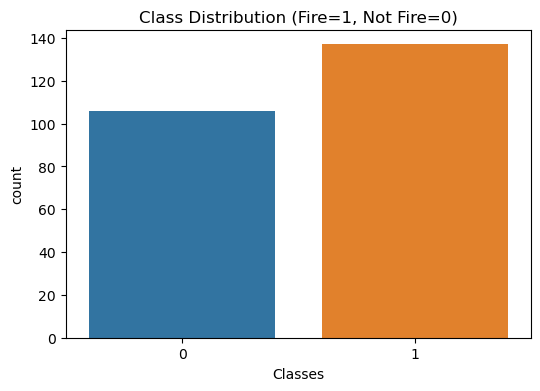

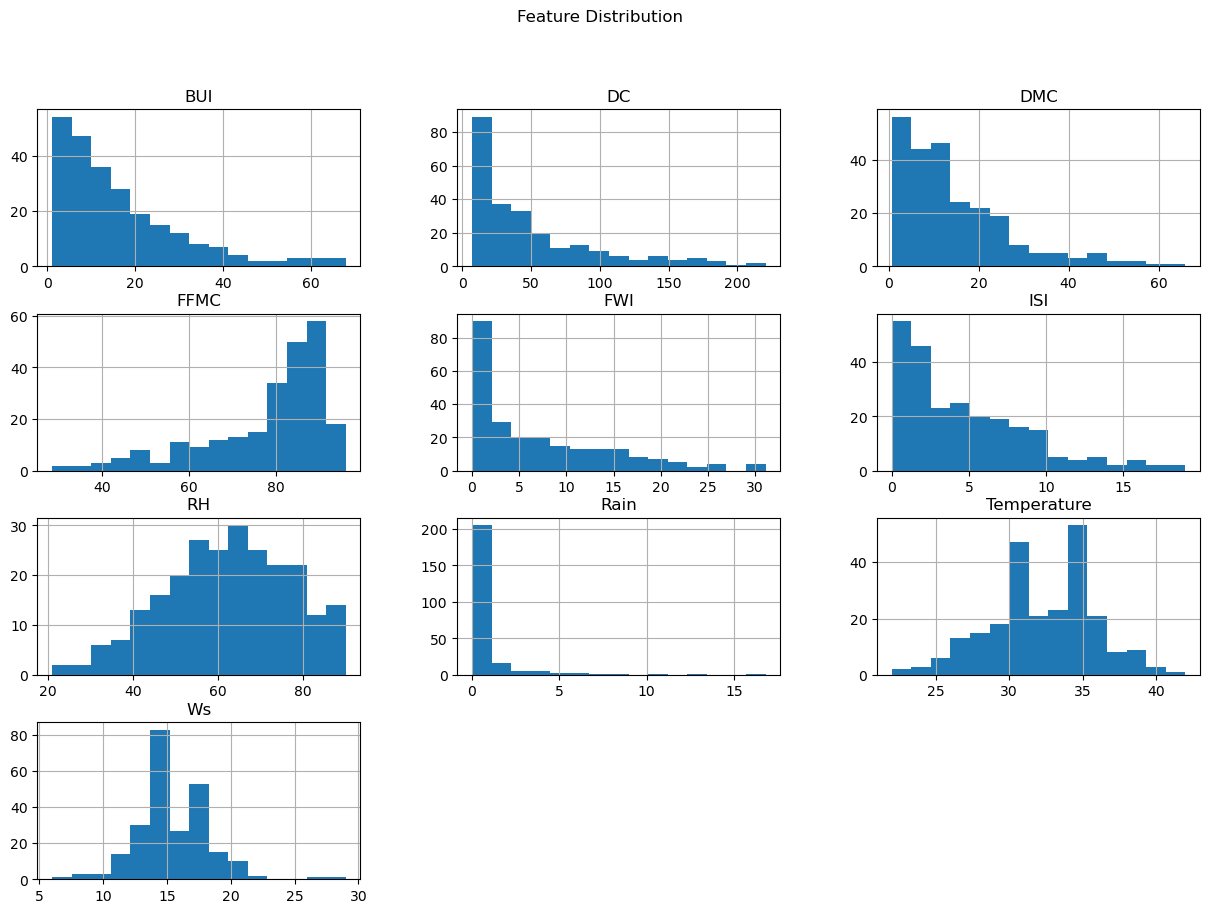

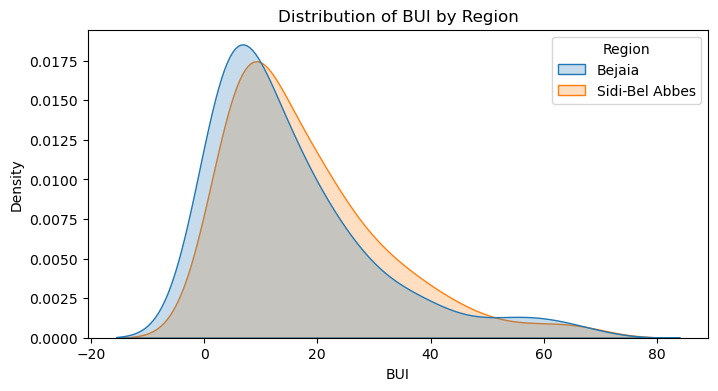

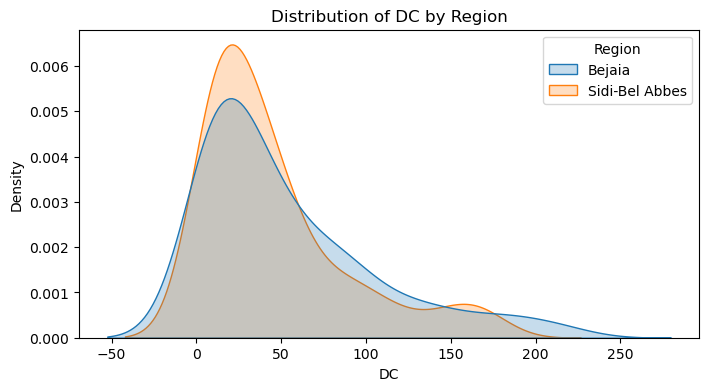

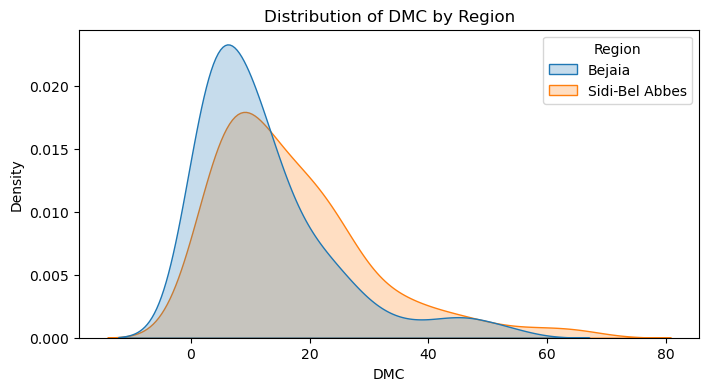

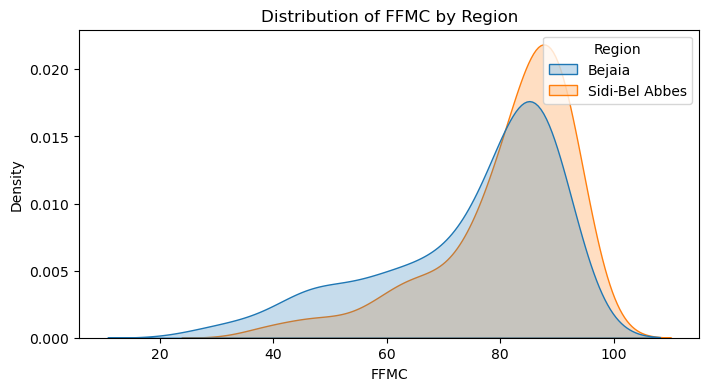

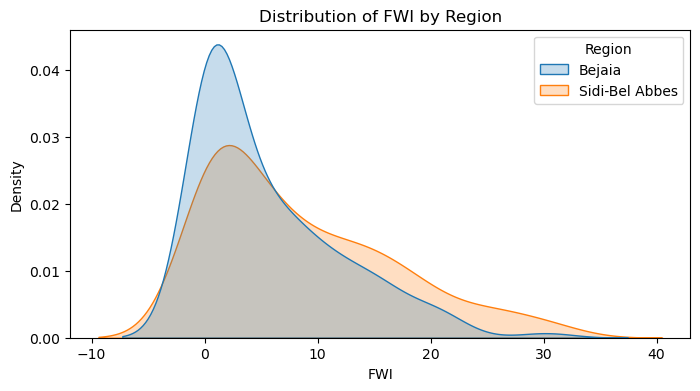

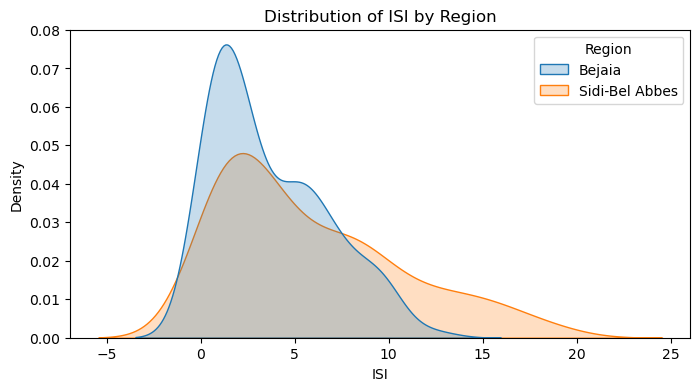

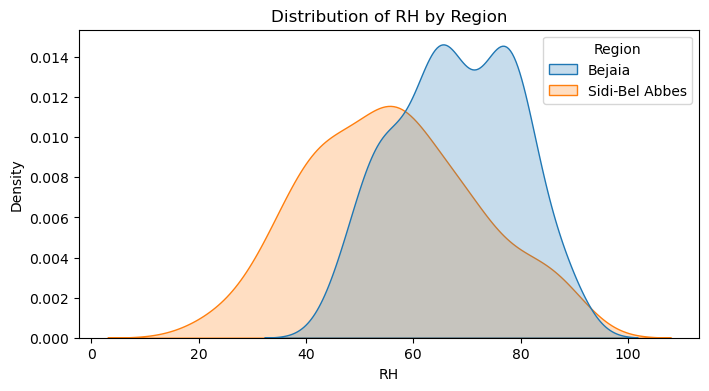

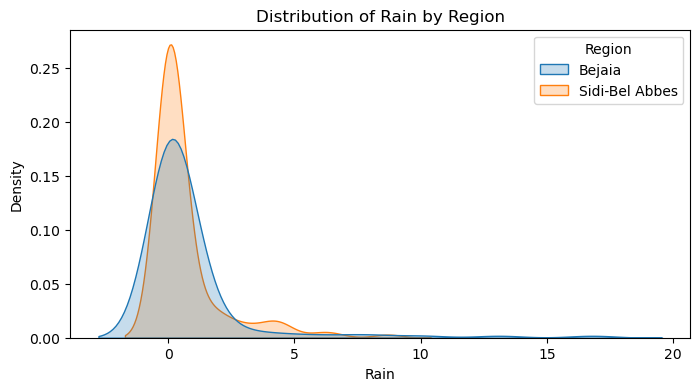

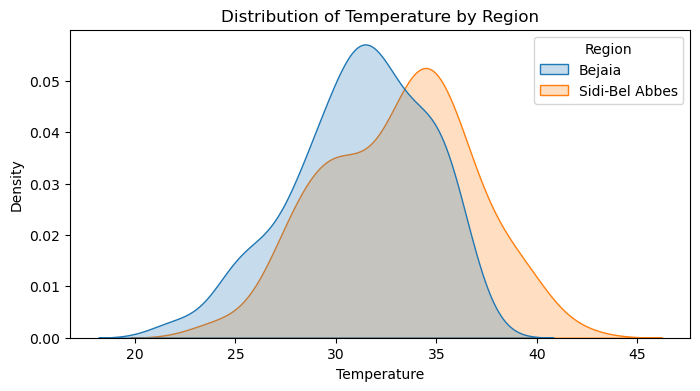

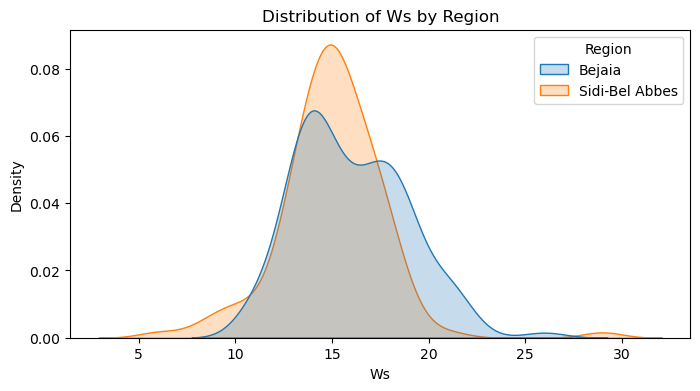

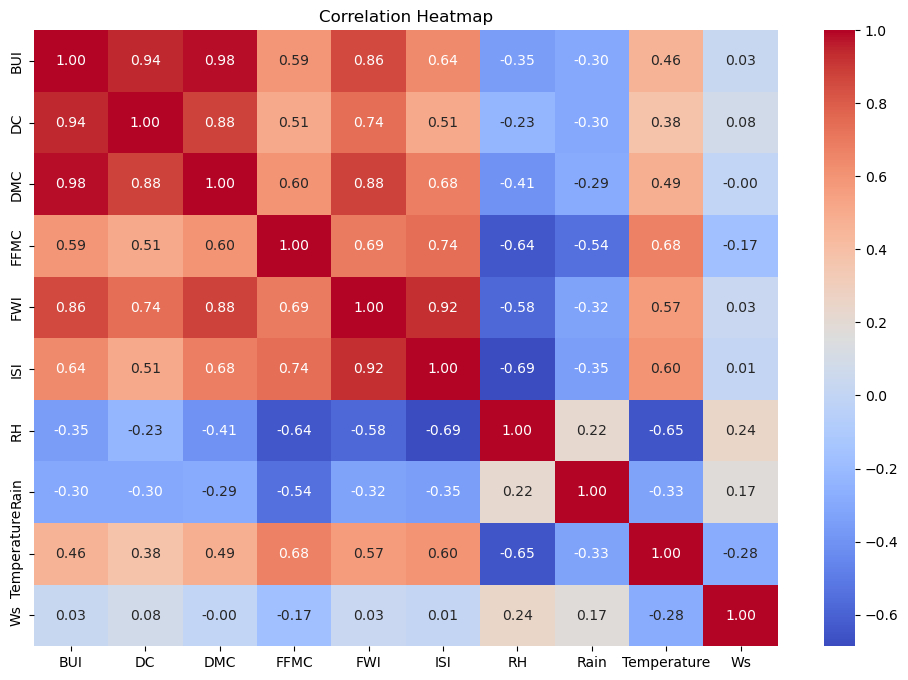

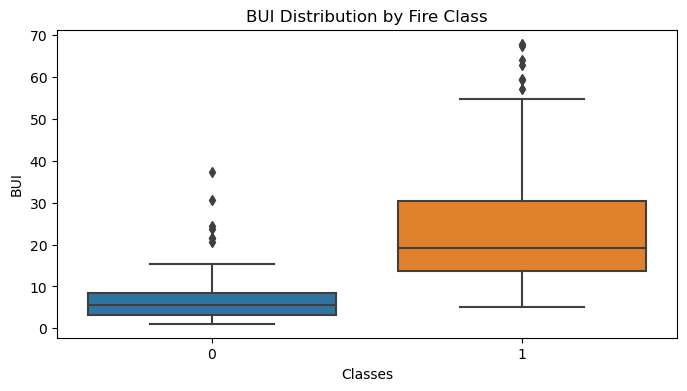

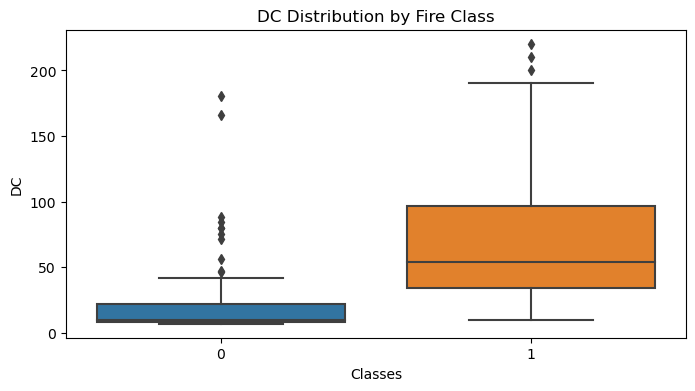

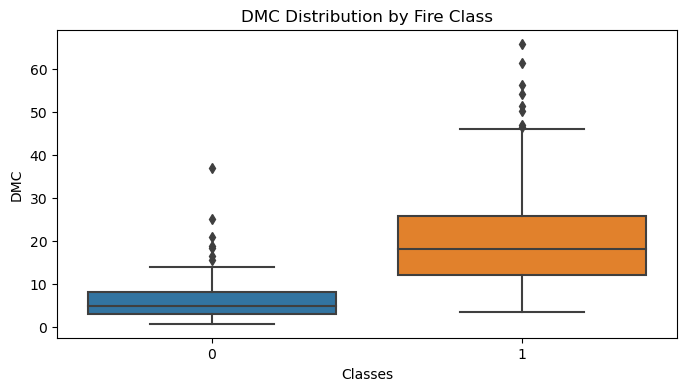

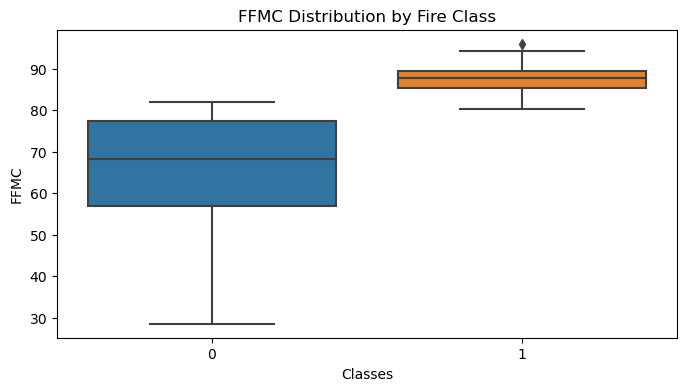

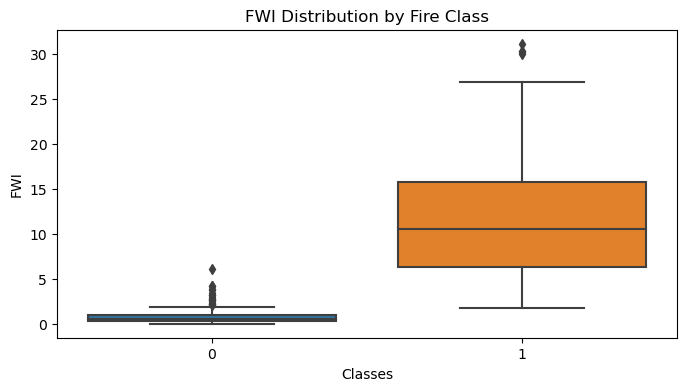

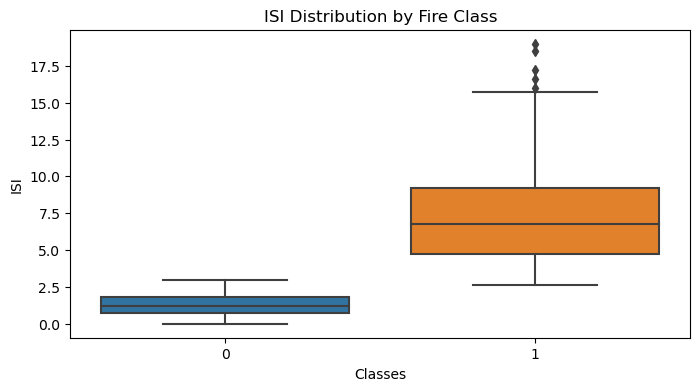

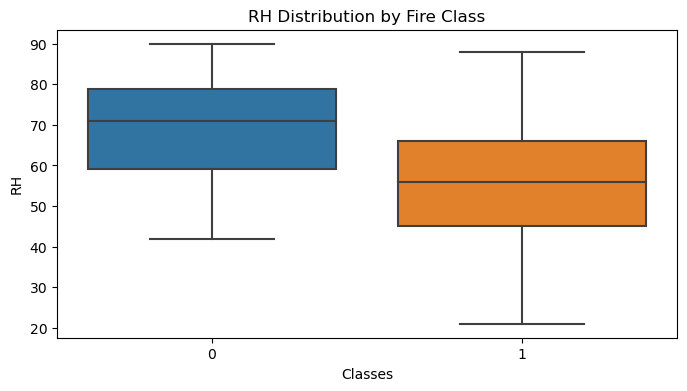

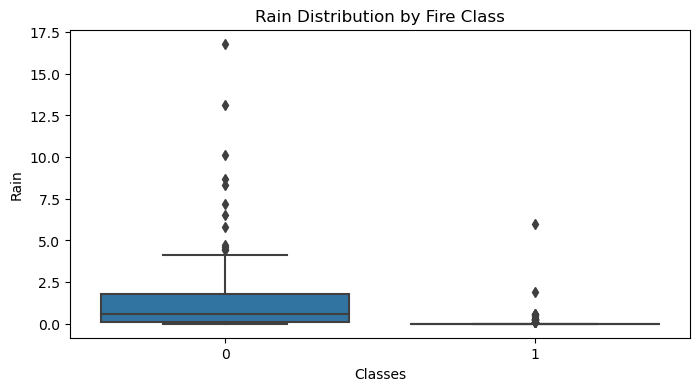

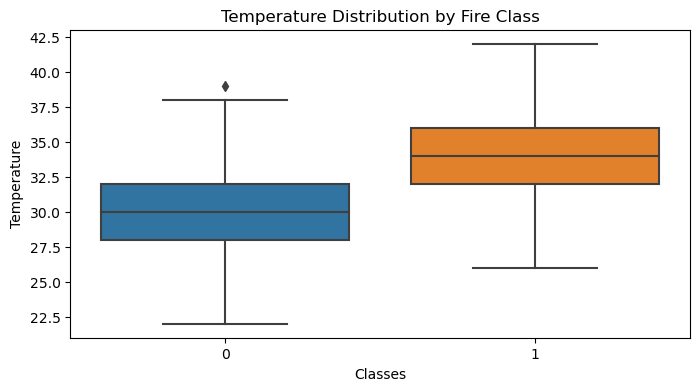

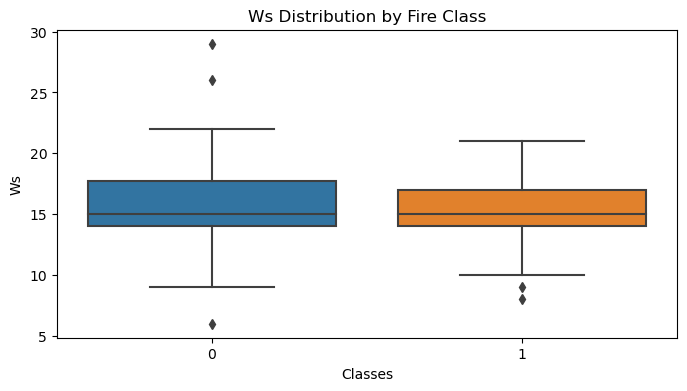

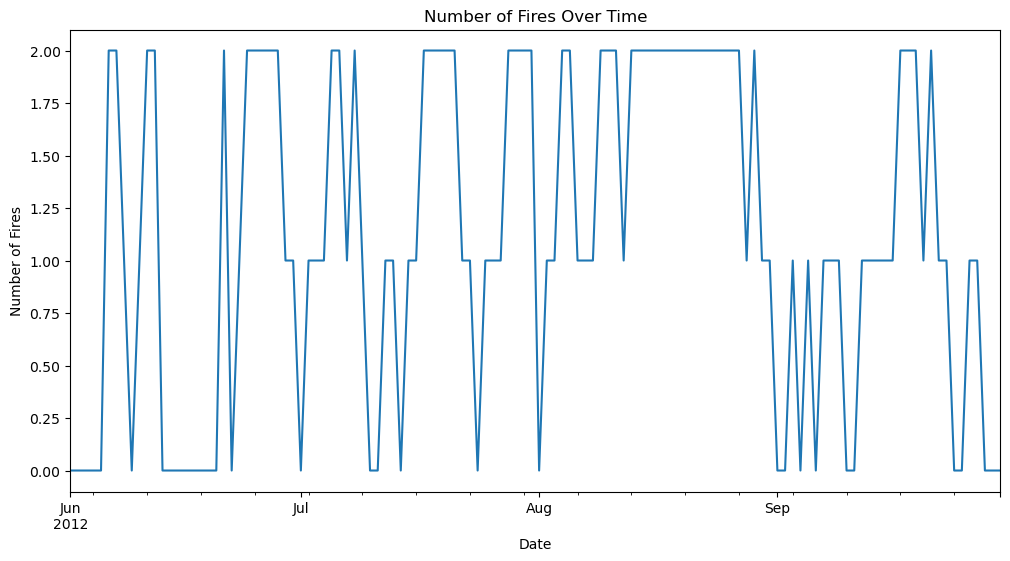

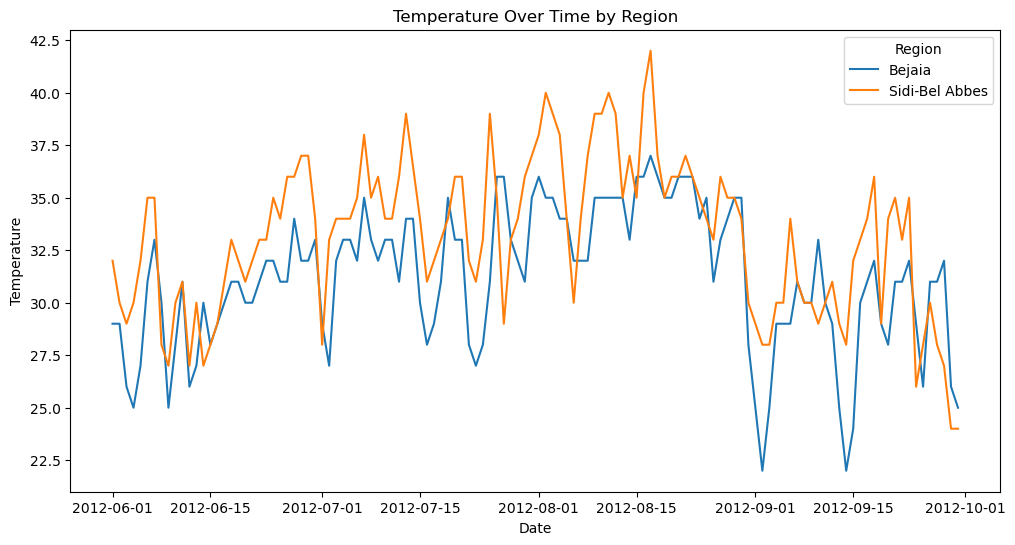

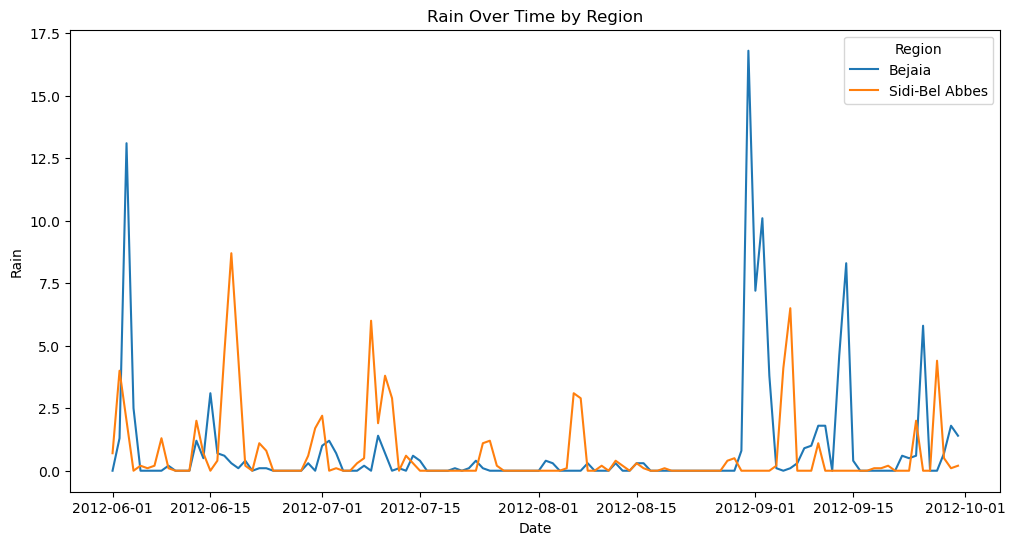

In [25]:
# 3. EDA
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x='Classes', data=df)
plt.title("Class Distribution (Fire=1, Not Fire=0)")
plt.show()
numeric_cols = df.columns.difference(['Classes', 'Region', 'Date'])
df[numeric_cols].hist(bins=15, figsize=(15,10))
plt.suptitle("Feature Distribution")
plt.show()
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=df, x=col, hue='Region', fill=True)
    plt.title(f'Distribution of {col} by Region')
    plt.show()
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='Classes', y=col, data=df)
    plt.title(f'{col} Distribution by Fire Class')
    plt.show()
plt.figure(figsize=(12,6))
fires_over_time = df.groupby('Date')['Classes'].sum()
fires_over_time.plot()
plt.title("Number of Fires Over Time")
plt.ylabel('Number of Fires')
plt.show()
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='Temperature', hue='Region')
plt.title('Temperature Over Time by Region')
plt.show()
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='Rain', hue='Region')
plt.title('Rain Over Time by Region')
plt.show()


In [26]:
# =======================
# 4. Outlier detection (as you did)
# =======================
print("Outlier Detection")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    print(f"{col}: {len(outliers)} outliers")


Outlier Detection
BUI: 11 outliers
DC: 14 outliers
DMC: 12 outliers
FFMC: 13 outliers
FWI: 4 outliers
ISI: 4 outliers
RH: 0 outliers
Rain: 35 outliers
Temperature: 2 outliers
Ws: 8 outliers


Visualizing Outliers 



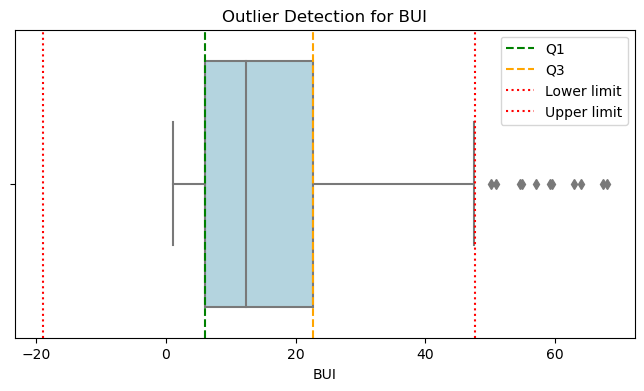

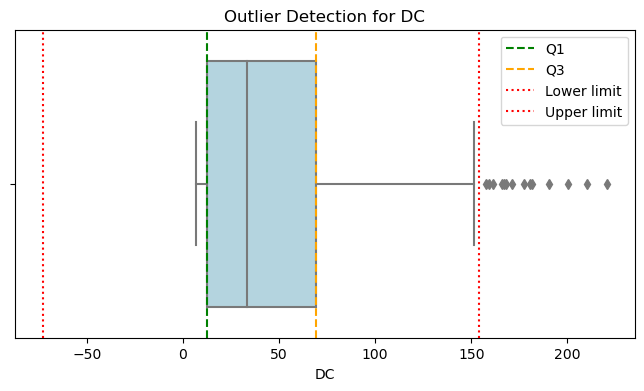

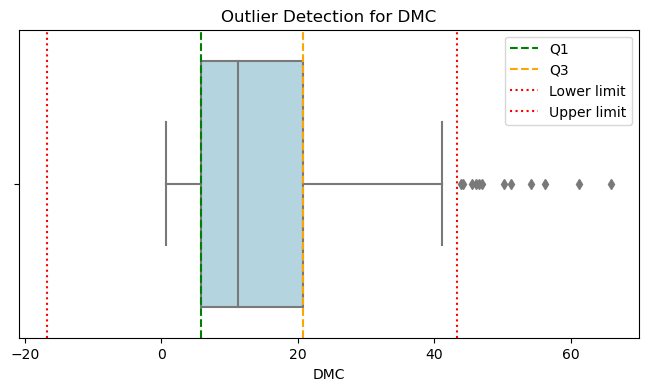

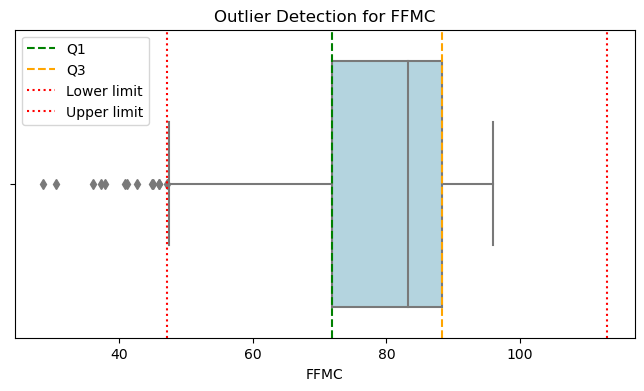

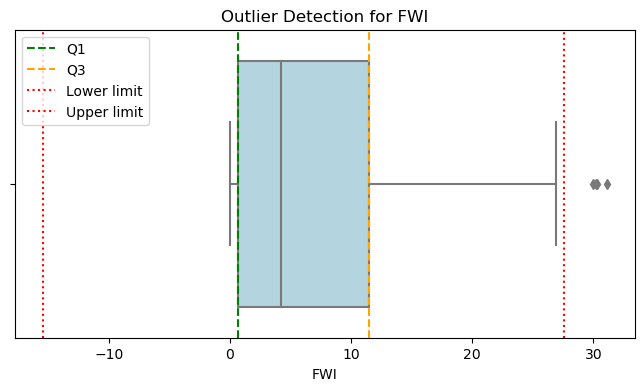

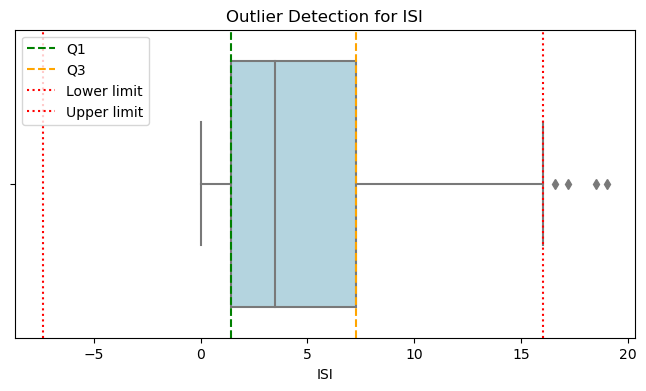

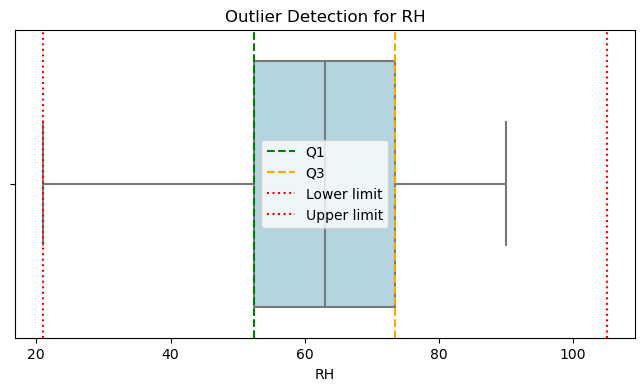

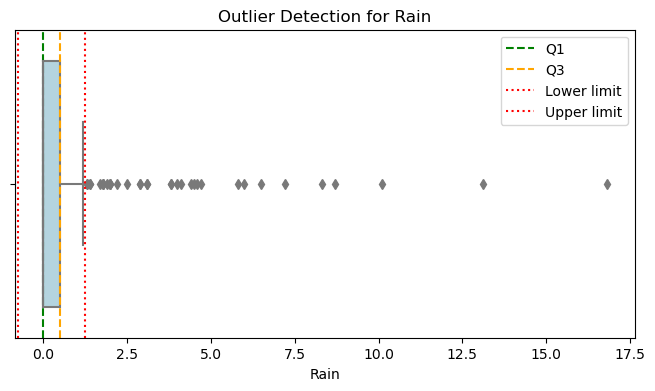

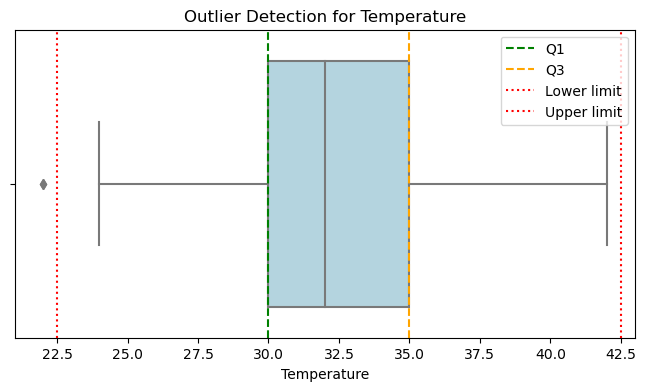

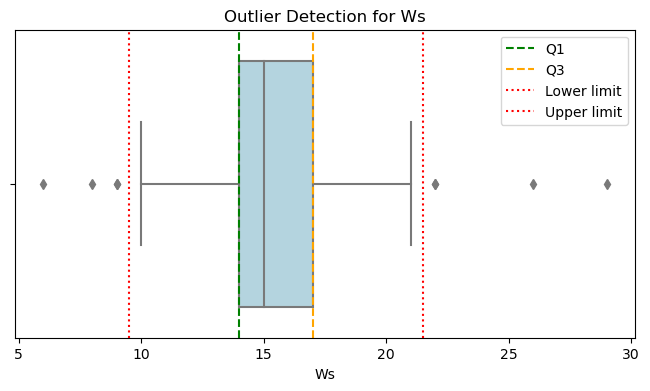

In [27]:
# 5. Visualizing outliers
print("Visualizing Outliers \n")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], color='lightblue')
    plt.axvline(Q1, color='green', linestyle='--', label='Q1')
    plt.axvline(Q3, color='orange', linestyle='--', label='Q3')
    plt.axvline(lower_limit, color='red', linestyle=':', label='Lower limit')
    plt.axvline(upper_limit, color='red', linestyle=':', label='Upper limit')
    plt.title(f"Outlier Detection for {col}")
    plt.legend()
    plt.show()


In [28]:
# 6. Outlier treatment
df1 = df.copy()
for col in numeric_cols:
    Q1 = df[col].quantile(0.10)
    Q3 = df[col].quantile(0.90)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df1[col] = df[col].clip(lower, upper)

In [29]:
# 7. Scaling with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_cols = ['Temperature', 'RH', 'Ws', 'Rain',
              'FFMC', 'DMC', 'DC', 'ISI', 'BUI']
df_scaled = df1.copy()
df_scaled[scale_cols] = scaler.fit_transform(df1[scale_cols])
print(df_scaled[scale_cols].describe())

        Temperature          RH            Ws          Rain          FFMC  \
count  2.430000e+02  243.000000  2.430000e+02  2.430000e+02  2.430000e+02   
mean  -7.456313e-16    0.000000 -5.848088e-17 -3.472302e-17  1.125757e-15   
std    1.002064e+00    1.002064  1.002064e+00  1.002064e+00  1.002064e+00   
min   -2.804054e+00   -2.773497 -3.405665e+00 -4.845682e-01 -3.438694e+00   
25%   -5.944548e-01   -0.644776 -5.346274e-01 -4.845682e-01 -4.184603e-01   
50%   -4.205512e-02    0.064797 -1.757477e-01 -4.845682e-01  3.811160e-01   
75%    7.865444e-01    0.774371  5.420118e-01 -8.649494e-02  7.302759e-01   
max    2.719943e+00    1.889415  4.489689e+00  3.496165e+00  1.267982e+00   

                DMC            DC           ISI           BUI  
count  2.430000e+02  2.430000e+02  2.430000e+02  2.430000e+02  
mean  -1.900629e-16  8.041121e-17 -1.754427e-16 -8.041121e-17  
std    1.002064e+00  1.002064e+00  1.002064e+00  1.002064e+00  
min   -1.130434e+00 -8.941174e-01 -1.143935e+00 -1

In [30]:
print("Scaler n_features_in_:", scaler.n_features_in_)
print("scale_cols:", scale_cols)

Scaler n_features_in_: 9
scale_cols: ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']


In [31]:
# 8. Train DecisionTree Regressor to predict FWI
X = df_scaled.drop(['FWI', 'Classes', 'Region', 'Date'], axis=1)
y = df_scaled['FWI']
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.8775510204081632
MSE: 2.2877551020408164
R²: 0.9245175106622847


In [33]:
# 9. Save model, scaler, and feature order for FastAPI/Streamlit
import joblib
joblib.dump(model, "forest_fire_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(list(X.columns), "feature_order.pkl")
print("Saved. Scaler n_features_in_:", scaler.n_features_in_)
print("X.columns:", list(X.columns))

Saved. Scaler n_features_in_: 9
X.columns: ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI']
